# EU Referendum Odds

I scraped the SkyBet odds on the EU referendum for a while in the run up to see how the odds changed. This notebook shows how I scraped it & what the data look like.

## Getting data

I scraped the SkyBet odds using PhantomJS. I don't have a server at home so I borrowed one from Amazon & used Ansible to provision it to run a Docker container. The Docker container repeatedly loads the SkyBet page and dumps out the odds by pulling them out of the page using JQuery.

On the odds of an event are within an `a` tag & have the CSS class `oc-odds-desc`. Each has an attribute for the numerator and denominator of the odds. The PhantomJS script in `app/grab.js` hoovers up every odds entry on the page and dumps it as a timestamped JSON object.

The restart policy of the Docker container is set to `always` which means the script will poll the page as quickly as possible.

## Transforming it

The `Makefile` in the root of the repository shows one quick post-processing step to make it easier to parse; as the JSON objects include commas, the comma was a bad choice of delimiter in the log file. To get around that I convert the first comma to a pipe with sed and use that as a delimeter instead.

## Loading the data into R

Getting the data into R is quick with read.table, but there are some transformations that need to be done on the date and the odds JSON objects.

In [28]:
data <- read.table('logs.tab', sep="|",stringsAsFactors = F,quote = '')
library(dplyr)
library(tidyr)
library(jsonlite)

### Fixing the date

The date needs to be parsed first. The datestams include two different timezones (with the same offset) which mean the offset can't just be included in the format string when parsing it. Instead, it needs cutting off before the date can be parsed.

In [29]:
data <- data %>%
    separate(V1,c("date","offset"),sep = c(25)) %>%
    mutate(datetime=as.POSIXct(strptime(date,format="%a %b %e %Y %H:%M:%S"),tz='GMT'))
data %>% tail

date         offset
112053 Tue Jun 21 2016 09:13:35  GMT+0000 (UTC)
112054 Tue Jun 21 2016 09:21:48  GMT+0000 (UTC)
112055 Tue Jun 21 2016 09:29:02  GMT+0000 (UTC)
112056 Tue Jun 21 2016 09:35:14  GMT+0000 (UTC)
112057 Tue Jun 21 2016 09:43:26  GMT+0000 (UTC)
112058 Tue Jun 21 2016 09:50:35  GMT+0000 (UTC)
                                                                                                                                                                                                                                            V2
112053 {"UK to leave":{"data-oc-handicap-value":"0.0","data-oc-price-den":"4","data-oc-price-num":"11","data-oc-type":"ST"},"UK to stay":{"data-oc-handicap-value":"0.0","data-oc-price-den":"4","data-oc-price-num":"1","data-oc-type":"ST"}}
112054 {"UK to leave":{"data-oc-handicap-value":"0.0","data-oc-price-den":"4","data-oc-price-num":"11","data-oc-type":"ST"},"UK to stay":{"data-oc-handicap-value":"0.0","data-oc-price-den":"4","data-oc-price-num":"1","data-oc-type":"ST"}}
112055 {"UK to leave":{"data-oc-handicap-value":"0.0","data-oc-price-den":"4","data-oc-price-num":"11","data-oc-type":"ST"},"UK to stay":{"data-oc-handicap-value":"0.0","data-oc-price-den":"4","data-oc-price-num":"1","data-oc-type":"ST"}}
112056 {"UK to leave":{"data-oc-handicap-value":"0.0","data-oc-price-den":"4","data-oc-price-num":"11","data-oc-type":"ST"},"UK to stay":{"data-oc-handicap-value":"0.0","data-oc-price-den":"4","data-oc-price-num":"1","data-oc-type":"ST"}}
112057 {"UK to leave":{"data-oc-handicap-value":"0.0","data-oc-price-den":"4","data-oc-price-num":"11","data-oc-type":"ST"},"UK to stay":{"data-oc-handicap-value":"0.0","data-oc-price-den":"4","data-oc-price-num":"1","data-oc-type":"ST"}}
112058 {"UK to leave":{"data-oc-handicap-value":"0.0","data-oc-price-den":"4","data-oc-price-num":"11","data-oc-type":"ST"},"UK to stay":{"data-oc-handicap-value":"0.0","data-oc-price-den":"4","data-oc-price-num":"1","data-oc-type":"ST"}}
                  datetime
112053 2016-06-21 09:13:35
112054 2016-06-21 09:21:48
112055 2016-06-21 09:29:02
112056 2016-06-21 09:35:14
112057 2016-06-21 09:43:26
112058 2016-06-21 09:50:35

### Extracting the JSON

The JSON objects in each row need to be turned into several columns. `tidyr` makes this easy using unnest which turns a data frame in a cell into a row. At some point the page changed from just presenting the Stay & Remain odds to percentages. I only have a few samples for these so filter them out, keeping only samples that have the straight Stay/Remain numbers.

`jsonlite` makes it easy to parse JSON --- it returns a `list` with the same structure. De-mangling this hierarchy into a few cells is less easy. The code below does that by:

1. Parsing the JSON
2. Generating a vector of the denominator and numerator for each event
3. Flattening the list of two vectors (one element for each event) into one vector
4. Transposing the vector into a row
5. Coercing it to a data frame

Doing this on the whole column of JSON strings generates a list of `data.frames`. The `unnest` function from `tidyr` turns those individual data frames into columns in the parent frame.

In [31]:
present <- function(json){
    as.logical(lapply(json,function(j){
        obj <- fromJSON(j)
        all(c("UK to leave","UK to stay") %in% names(obj))
    }))
}
extract <- function(json){
    lapply(json,function(j){
        obj <- fromJSON(j)
        data.frame(t((do.call(c,lapply(obj, function(x)(c(den=as.numeric(x$`data-oc-price-den`), num=as.numeric(x$`data-oc-price-num`))))))))
    })
}

odds <- data %>% 
    filter(present(V2)) %>%
    mutate(object = extract(V2)) %>%
    unnest(object)

## Decimal odds and implied probability

Decimal odds are easier to visualise but the subject here is the implied probability. These transforms are straightforward to compute:

In [45]:
with.decimal <- odds %>% mutate(
    leave = (UK.to.leave.den + UK.to.leave.num) / UK.to.leave.den,
    remain = (UK.to.stay.den + UK.to.stay.num)  / UK.to.stay.den
) %>% 
mutate(implied_remain = 1/remain, implied_leave=1/leave)


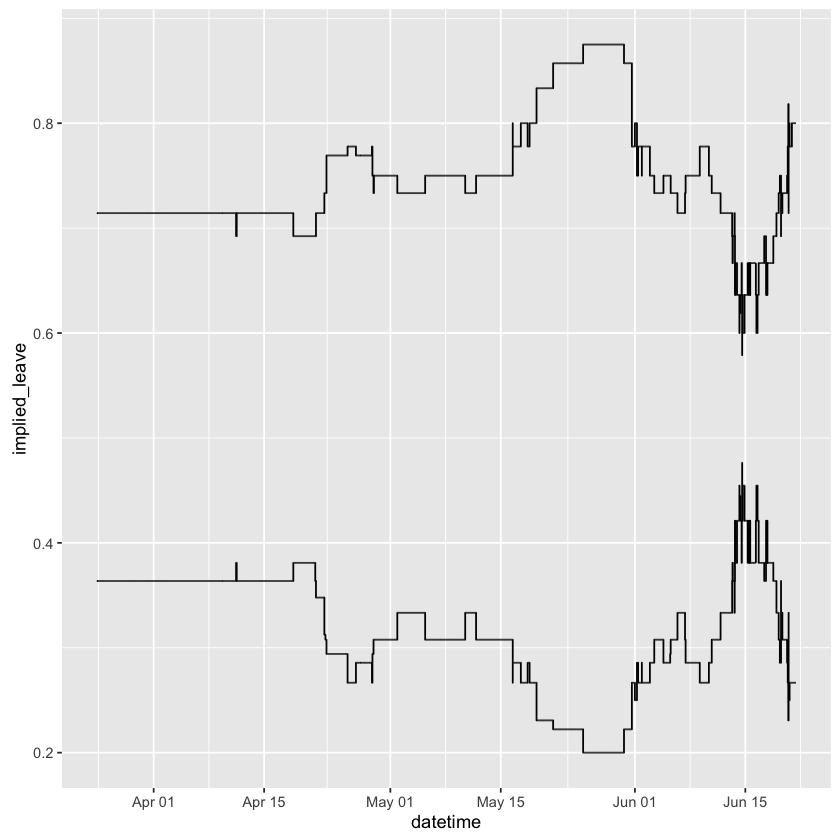

In [46]:
library(ggplot2)

with.decimal %>% 
ggplot(aes(datetime,y=implied_leave)) + 
    geom_line() + 
    geom_line(aes(y=implied_remain))

### Refining the plot

The plot shows the data but it's not clear enough. We can colour the lines by the series to make it less ambiguous. It's easiest to do that with the data in "long" format where we have one row per observed variable and date.

In [39]:
long <- with.decimal %>% 
    select(datetime,leave,remain) %>% 
    gather(outcome,decimal_odds,leave,remain,total) %>%
    mutate(implied_probability = 1/decimal_odds)

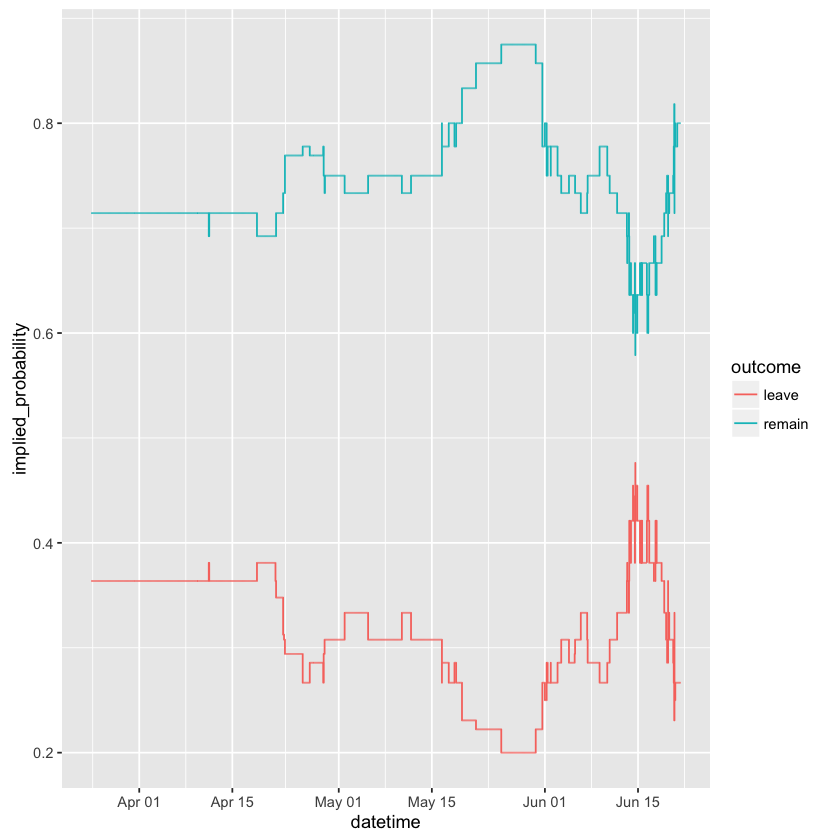

In [41]:
long %>% ggplot(aes(datetime,implied_probability,colour=outcome)) + geom_line()

## Exploring the vigorish/rake

The implied odds let us see what [rake](https://en.wikipedia.org/wiki/Vigorish#Vigorish_percentage) the bookmaker wanted to make. We can plot this over time too.

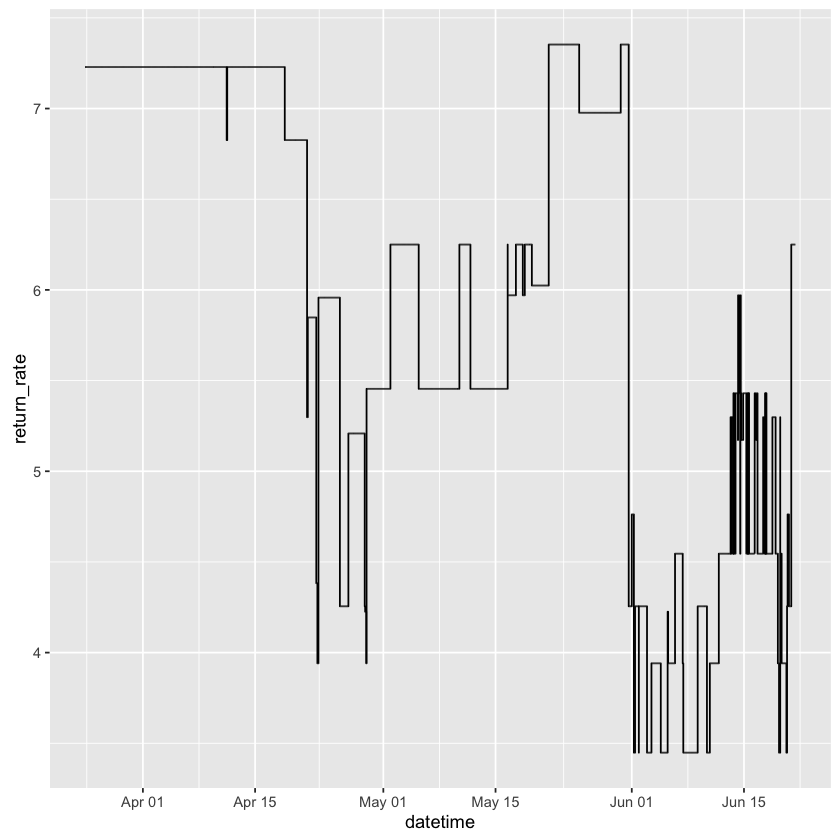

In [51]:
with.decimal %>% 
mutate(return_rate = 100 * (1-(leave * remain)/(leave+remain))) %>%
ggplot(aes(datetime,y=return_rate)) + 
    geom_line() 